# Bibliotecas
Aqui vamos carregar as bibliotecas necessárias

In [25]:
import pandas as pd
import pandas_gbq
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px


# Função para garantir reviews únicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")


# 1. Baixar léxico VADER (executar apenas uma vez)
nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\awebe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\awebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importando Dados
Aqui vamos fazer a conexão com o BigQuery

In [26]:
# 2. Carregar dados do BigQuery
project_id = "projeto4lab"
dataset    = "proj04"
tabela     = "amazon_uniao"

query = f"""
SELECT *
FROM `{project_id}.{dataset}.{tabela}`
"""

df = pandas_gbq.read_gbq(
    query,
    project_id=project_id,
    dialect="standard",
    use_bqstorage_api=False
)


Downloading: 100%|██████████|


# Análise de Sentimento e NLP 

In [27]:
# 3. Função para limpar texto
def limpar_texto(texto):
    if not texto or pd.isna(texto):
        return ""
    texto = str(texto)
    texto = re.sub(r"[^\x00-\x7F]+", "", texto)   # remove emojis/símbolos
    texto = re.sub(r"[\.,;:!\?\-]+", ". ", texto)  # força pontuações
    texto = re.sub(r"\s+", " ", texto)             # normaliza espaços múltiplos
    return texto.strip()

# 4. Criar coluna com texto completo (título + conteúdo) e limpar
df["texto_completo"] = df["review_title"].fillna("") + " " + df["review_content"].fillna("")
df["texto_completo"] = df["texto_completo"].apply(limpar_texto)

# 5. Instanciar VADER
analyzer = SentimentIntensityAnalyzer()

# 6. Lista de expressões negativas
palavras_negativas = [
    "not working",
    "does not work",
    "doesn’t work",
    "won’t turn on",
    "stopped working",
    "broken",
    "defective",
    "malfunctioning",
    "no power",
    "battery life is 0",
    "battery life is very poor",
    "won't charge",
    "charging issue",
    "overheats",
    "poor battery",
    "short battery life",
    "disconnects",
    "unstable connection",
    "no signal",
    "dropped calls",
    "keeps crashing",
    "freezes",
    "laggy",
    "slow",
    "delayed response",
    "doesn't fit",
    "not fitting",
    "loose fit",
    "poor fitting",
    "fragile",
    "cheap build",
    "cheap material",
    "low quality",
    "poor quality",
    "subpar",
    "terrible quality",
    "waste of money",
    "not worth",
    "not worth the hype",
    "overpriced",
    "ripoff",
    "scam",
    "fake",
    "counterfeit",
    "useless",
    "disappointed",
    "not as advertised",
    "false advertising",
    "misleading",
    "did not meet expectations",
    "poor performance",
    "broke quickly",
    "horrible",
    "worst product",
    "hate it",
    "never again",
    "do not buy",
    "missing parts",
    "customer service sucks",
    "hard to use",
    "poor instructions",
    "missing accessories",
    "wrong item",
    "not as described",
    "bad quality",
    "not so good",
    "not much powerful",
    "not how original remote works",
    "chinese quality",
    "but is not 65w as advertised"
]

# 7. Lista de expressões positivas compostas
palavras_positivas = [
    "works great",
    "high quality product",
    "worth every penny",
    "exceeded expectations",
    "five star",
    "works perfectly",
    "very satisfied",
    "highly recommend",
    "best purchase ever",
    "superb quality",
    "extremely happy",
    "in love with",
    "amazing performance",
    "great value",
    "top quality",
    "very impressed",
    "awesome product",
    "perfect condition",
    "exactly as described",
    "quick delivery",
    "easy to use",
    "user friendly",
    "simply awesome", 
    "nice product",
    "i recommend to buy"
]

# 8. Função de classificação final com critério de desempate
def classificar_sentimento(texto):
    lower = texto.lower()

    # Contar quantas ocorrências de expressões negativas e positivas
    neg_count = sum(1 for chave in palavras_negativas if chave in lower)
    pos_count = sum(1 for expressao in palavras_positivas if expressao in lower)

    total = neg_count + pos_count
    if total > 0:
        # Se houver pelo menos uma expressão, aplica desempate por contagem
        if neg_count > pos_count:
            return "reclamacao"
        elif pos_count > neg_count:
            return "elogio"
        else:
            return "neutro"

    # 3) Se não encontrou nenhuma expressão explícita, usar VADER
    comp = analyzer.polarity_scores(texto)["compound"]
    if comp >= 0.05:
        return "elogio"
    elif comp <= -0.05:
        return "reclamacao"
    else:
        return "neutro"

# 9. Aplicar ao DataFrame completo
df["sentimento_ajustado"] = df["texto_completo"].apply(classificar_sentimento)

# 10. Exibir distribuição de rótulos e exemplos
print("\nDistribuição (com critério de desempate):")
print(df["sentimento_ajustado"].value_counts())

print("\nExemplo de registros com sentimento ajustado:")
print(df[["texto_completo", "sentimento_ajustado"]].head(30))

# 11. Palavras mais frequentes categorizadas (segmentação por tema)
palavras_frequentes_categorizadas = {
    "experience": [
        "not as expected", "disappointed", "not worth", "waste of money",
        "not like description", "did not meet expectations", "looks different",
        "easy to use", "user friendly", "hard to use", "difficult to use",
        "simple interface", "setup was easy", "very satisfied", "not satisfied",
        "extremely happy", "not happy", "happy with purchase", "regret buying"
    ],
    "functionality": [
        "didnt work", "doesnt work", "not working", "stopped working",
        "broken product", "useless product", "malfunctioning", "defective item",
        "worked fine", "works well", "worked for a month", "after few days", "used for weeks"
    ],
    "quality": [
        "good quality", "bad quality", "poor quality", "product quality", "good quality product",
        "cheap material", "build quality", "high quality", "low quality", "superior quality"
    ],
    "service": [
        "customer care", "customer support", "support", "helpful service", "good support", "service center",
        "bad service", "poor service", "no support", "unhelpful", "rude staff", "ignored complaint",
        "no response", "bad customer care"
    ],
    "delivery": [
        "fast delivery", "quick delivery", "on time delivery", "delivery time",
        "late delivery", "slow delivery", "bad delivery", "missing item", "lost package",
        "damaged on arrival", "delayed shipping", "did not arrive", "item arrived late", "courier service"
    ],
    "price": [
        "price range", "price point", "price segment", "great value", "worth buying", "tight budget", "value for money"
    ]
}

def categorizar_por_keywords(texto):
    lower = texto.lower()
    for categoria, palavras in palavras_frequentes_categorizadas.items():
        for palavra in palavras:
            if palavra in lower:
                return categoria
    return "other"

df["tema_categoria"] = df["texto_completo"].apply(categorizar_por_keywords)

print("\nDistribuição por tema:")
print(df["tema_categoria"].value_counts())

print("\nExemplo de registros finais:")
print(df[["texto_completo", "sentimento_ajustado", "tema_categoria"]].head(10))


Distribuição (com critério de desempate):
sentimento_ajustado
elogio        818
reclamacao    374
neutro        158
Name: count, dtype: int64

Exemplo de registros com sentimento ajustado:
                                       texto_completo sentimento_ajustado
0   The cable works but is not 65W as advertised I...          reclamacao
1   Awesome Product Quick delivery. Awesome Produc...              elogio
2   Good. Superb quality. Good products nice one. ...              elogio
3   Very responsive and stylish mouse. Simply Awes...              elogio
4   Not good. No voice recognition. No pointer ray...          reclamacao
5   Rmote for MI TV. Good. Good but low quality. R...          reclamacao
6   Its is good but battery life is very poor. Hea...          reclamacao
7   Very Good prodat. Battery life is 0 day. Good....              neutro
8   Bad quality. Amazing product. The heating capa...          reclamacao
9   It's good . Good. Good Product. Satisfied. Goo...              elo

In [28]:
df["tema_categoria"].value_counts()


tema_categoria
experience       451
quality          297
functionality    224
price            169
other            147
service           58
delivery           4
Name: count, dtype: int64

# EDA

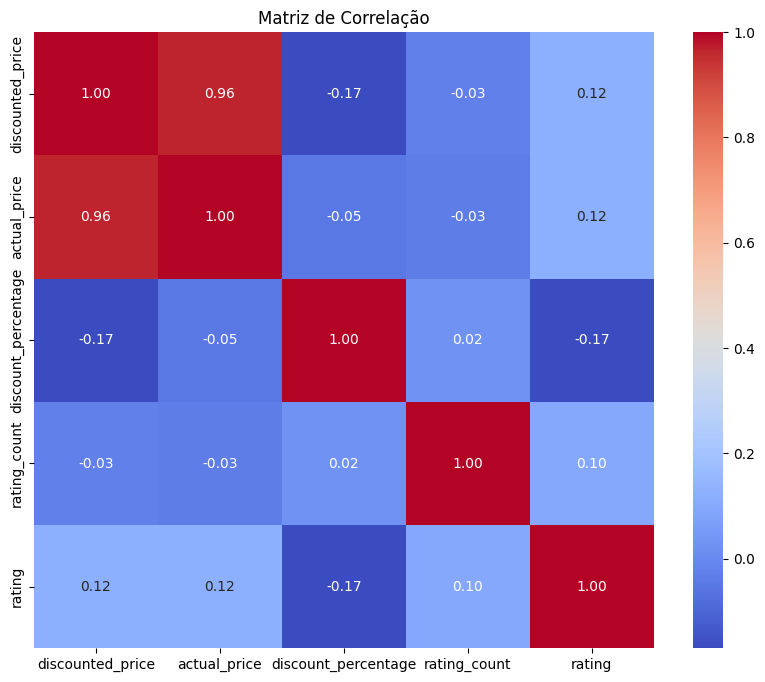

In [29]:
# Filtrar reviews únicos (usando review_id)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Plot da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_unique_reviews[[ 
    "discounted_price", "actual_price", "discount_percentage", 
    "rating_count", "rating"
]].corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Matriz de Correlação")
plt.show()



Percebe-se a alta correlação entre actual_price e discounted_price. Para as análises teremos que utilizar apenas 1 deles, escolhi trabalhar com o discounted_price.

In [30]:
fig = px.histogram(df.drop_duplicates(subset="review_id"), 
                   x="rating", nbins=20, 
                   title="Distribuição de Ratings")
fig.show()


In [31]:
fig = px.scatter(df.drop_duplicates(subset="review_id"), 
                 x="discounted_price", y="rating", 
                 color="primeira_categoria", 
                 title="Preço com Desconto vs Rating")
fig.show()

c:\Users\awebe\OneDrive\Área de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



A análise do gráfico de dispersão mostrou que não há correlação linear forte entre o preço com desconto e o rating. Produtos mais caros não garantem ratings melhores, embora itens de preço muito elevado (acima de 30k) tendam a manter ratings altos (≥ 4).
A maioria dos produtos concentra-se em faixas de preço baixas (< 10k), com grande variabilidade nas avaliações. Produtos baratos apresentam alta dispersão de ratings, enquanto os mais caros são poucos e consistentemente bem avaliados.
A categoria Electronics predomina entre os produtos de preço elevado, enquanto as demais categorias se concentram em preços baixos e médios.

In [32]:
fig = px.box(df.drop_duplicates(subset="review_id"), 
             x="primeira_categoria", y="rating", 
             title="Distribuição de Rating por Categoria")
fig.show()


O gráfico mostra que, em geral, os produtos das diversas categorias recebem avaliações muito positivas, com mediana de rating acima de 4.0 na maior parte dos casos.
Algumas categorias, como Home&Kitchen e Electronics, apresentam maior variabilidade e outliers de ratings baixos, o que indica que nem todos os produtos atendem de forma consistente às expectativas dos consumidores.
Por outro lado, categorias como Health&PersonalCare e Toys&Games têm avaliações altamente consistentes e predominantemente positivas, evidenciando maior uniformidade na qualidade percebida pelos usuários.

In [33]:
fig = px.box(df.drop_duplicates(subset="review_id"), x="quartil_discount", y="rating", 
             title="Rating por Quartil de Desconto")
fig.show()


Ratings se mantêm relativamente estáveis em todos os quartis de desconto. Pequena tendência de redução no quartil 4 (maior desconto), o que pode sugerir percepção de menor qualidade em produtos muito promocionados.

In [34]:
fig = px.box(df.drop_duplicates(subset="review_id"), x="quartil_rating", y="tema_categoria", 
             title="Rating por Quartil de Desconto")
fig.show()


Produtos com temas como experience e os residuos (other) apresentam ratings mais lineares atingindo todas as pontuações. <br>
Delivery, quality e service ficaram com rating superiores a 2, num geral se colocando bem posicionados.<br>
Functionality é o tema que tem pior relação desconto com rating. <br>
Price mostram menor variação no rating conforme o desconto.<br>

In [35]:
fig = px.box(df.drop_duplicates(subset="review_id"), y="discounted_price", title="Outliers de Preço com Desconto")
fig.show()


Há presença de outliers significativos em produtos com preço com desconto acima de 40k, mas deve-se considerar a moeda utilizada e tipo de produto, uma vez que produtos eletrônicos possuem alto valor (neste caso a moeda utilizada é a rupia, no link do produto alguns similares se encontravam com o mesmo valor, então é um outlier real, produtos eletrônicos tem um valor mais expansivo, sentido ainda mais em moedas desvalorizadas).<br>
A maioria dos produtos está concentrada abaixo de 10k.

In [36]:
# Criar uma cópia temporária com reviews únicas (sem alterar df original)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar reviews únicas por primeira_categoria
cat_counts = df_unique_reviews["primeira_categoria"].value_counts().reset_index()
cat_counts.columns = ["primeira_categoria", "count"]

# Manter apenas as top 5 categorias
cat_counts = cat_counts.head(5)

# Gráfico
import plotly.express as px

fig = px.bar(cat_counts, x="primeira_categoria", y="count",
             title="Top 5 Categorias com mais Reviews")
fig.show()


Home & Kitchen, Electronics e Computers & Accessories são as categorias líderes em volume de reviews. <br>
Mostra que os consumidores são mais engajados em avaliar produtos desses segmentos.

In [37]:
# Criar uma cópia temporária com reviews únicas (sem alterar df original)
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar reviews únicas por ultima_categoria
cat_counts = df_unique_reviews["ultima_categoria"].value_counts().reset_index()
cat_counts.columns = ["ultima_categoria", "count"]

# Manter apenas as top 5 categorias
cat_counts = cat_counts.head(5)

# Gráfico
import plotly.express as px

fig = px.bar(cat_counts, x="ultima_categoria", y="count",
             title="Top 5 Categorias com mais Reviews")
fig.show()



USB Cables, Remote Controls e In-Ear são as categorias com mais reviews únicos. <br>
Isso indica alta popularidade e/ou maior volume de vendas para estes tipos de produtos.

In [38]:
# Filtrar reviews únicos por produto
df_unique_product = df.drop_duplicates(subset="product_id")

# Filtrar produtos com rating_count válido (> 0)
df_valid = df_unique_product[df_unique_product["rating_count"].notna() & (df_unique_product["rating_count"] > 0)]

# Scatter plot
fig = px.scatter(df_valid, 
                 x="rating_count", 
                 y="rating", 
                 title="Número de Avaliações vs Rating",
                 size="rating_count", 
                 color="primeira_categoria",
                 log_x=True)

fig.show()


c:\Users\awebe\OneDrive\Área de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Não há uma relação clara entre número de avaliações e rating médio.<br>
Produtos com muitas avaliações tendem a ter ratings mais concentrados em torno de 4.0 a 4.5.<br>
Produtos com menos avaliações mostram maior dispersão nos ratings (potencialmente mais sensíveis a avaliações individuais extremas).<br>

In [39]:
# Trabalhar com reviews únicos
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Agrupar por tema e sentimento
sent_tema = df_unique_reviews.groupby(["tema_categoria", "sentimento_ajustado"]).size().reset_index(name="count")

# Plot
fig = px.bar(sent_tema, 
             x="tema_categoria", 
             y="count", 
             color="sentimento_ajustado",
             barmode="group", 
             title="Sentimento por Tema")

fig.show()

c:\Users\awebe\OneDrive\Área de Trabalho\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Experience possui a maior quantidade de elogios, mas também um volume considerável de reclamações.<br>
Quality segue com muitos elogios e algumas reclamações.<br>
Functionality é a que mais apresenta reclamações.<br>
Price e Service são temas com reclamções proporcionalmente maiores em relação ao volume de observações.<br>

In [40]:
# Trabalhar com reviews únicos
df_unique_reviews = df.drop_duplicates(subset="review_id")

# Contar frequência de temas
tema_counts = df_unique_reviews["tema_categoria"].value_counts().reset_index()
tema_counts.columns = ["tema_categoria", "count"]

# Plot
fig = px.bar(tema_counts, 
             x="tema_categoria", 
             y="count",
             title="Frequência de Temas em Reviews",
             text="count")

fig.show()


O tema mais citado nas reviews é experience, seguido de quality e functionality. Temas como delivery e service aparecem com baixa frequência.
Aparentemente os consumidores focam mais em relatar experiências de uso do produto e sua qualidade percebida, enquanto questões logísticas (entrega/serviço) são menos recorrentes.

In [41]:
import plotly.express as px

# Gráfico
fig = px.scatter(df_unique_reviews, 
                 x="rating_count", 
                 y="rating", 
                 trendline="ols",  # <- linha de tendência
                 title="Produtos com mais avaliações tendem a ter ratings mais altos",
                 labels={"rating_count": "Rating Count", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

# Deixar a linha de tendência preta
fig.update_traces(selector=dict(mode='lines'), line=dict(color='black'))

fig.show()


In [42]:
import plotly.express as px

# Gráfico
fig = px.scatter(df_unique_reviews, 
                 x="discount_percentage", 
                 y="rating", 
                 trendline="ols",  # <- linha de tendência
                 title="A porcentagem do desconto influencia no rating",
                 labels={"discount_percentage": "Desconto", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

# Deixar a linha de tendência preta
fig.update_traces(selector=dict(mode='lines'), line=dict(color='black'))

fig.show()

In [43]:
import plotly.express as px

# Gráfico sem trendline (porque categoria não aceita OLS)
fig = px.scatter(df_unique_reviews, 
                 x="primeira_categoria", 
                 y="rating", 
                 title="A categoria do produto afeta o rating médio",
                 labels={"primeira_categoria": "Categoria", "rating": "Rating"})

# Deixar as bolinhas pretas
fig.update_traces(marker=dict(color='black'))

fig.show()


# Validação de Hipóteses

## Hipótese 1: Produtos com mais avaliações tendem a ter ratings mais altos (confirmada baixa) (selecionado)

In [44]:
# Usa a função que não altera a base
df_filtrado = filtra_reviews(df)

# Força tipo float
df_filtrado["rating"] = pd.to_numeric(df_filtrado["rating"], errors="coerce").astype("float64")
df_filtrado["rating_count"] = pd.to_numeric(df_filtrado["rating_count"], errors="coerce").astype("float64")

# Remove linhas com NaN
df_reg = df_filtrado[["rating", "rating_count"]].dropna()

# Regressão linear
import statsmodels.api as sm
X = sm.add_constant(df_reg["rating_count"])
y = df_reg["rating"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     10.90
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           0.000989
Time:                        19:52:47   Log-Likelihood:                -275.65
No. Observations:                1187   AIC:                             555.3
Df Residuals:                    1185   BIC:                             565.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0723      0.010    421.861   

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3340389183.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3340389183.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



O modelo de regressão linear indica que existe uma relação estatisticamente significativa entre o número de avaliações (rating_count) e a nota média (rating), mas essa relação é extremamente fraca: o modelo explica apenas 0,9% da variância do rating (R² = 0,009). O coeficiente de rating_count é positivo, mas com um efeito prático desprezível. Além disso, os resíduos apresentam autocorrelação e não seguem uma distribuição normal, o que compromete a validade do modelo. Conclui-se que rating_count isoladamente não é um bom preditor para rating.

## Hipótese 2: A categoria do produto afeta o rating médio (confimrmada) (selecionado)

In [93]:
# Filtrar reviews únicos
df_unico = filtra_reviews(df)

# Regressão com variável categórica usando reviews únicos
modelo_categoria = smf.ols("rating ~ C(primeira_categoria)", data=df_unico).fit()

# Exibir resultado
print(modelo_categoria.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.860
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           2.29e-07
Time:                        11:26:27   Log-Likelihood:                -268.04
No. Observations:                1189   AIC:                             554.1
Df Residuals:                    1180   BIC:                             599.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

O modelo de regressão linear avalia o impacto das categorias de produto (primeira_categoria) na nota média (rating). O modelo é estatisticamente significativo (p < 0,001), porém seu poder explicativo é baixo (R² = 3,8%), indicando que as categorias explicam apenas uma pequena parcela da variação nas avaliações. Nenhuma das categorias apresenta efeito individual estatisticamente significativo (p > 0,05), sugerindo que as diferenças entre categorias não têm impacto consistente sobre o rating. O modelo também apresenta autocorrelação nos resíduos (Durbin-Watson = 0,246) e violação da normalidade, o que limita a robustez das conclusões.

## Hipótese 3: Existe uma associação entre a porcentagem de desconto e o rating. (confirmada) (selecionado)

In [45]:
# define a função regressao_limpa
def regressao_limpa(df, y_col, x_col):
    df_temp = df[[y_col, x_col]].dropna()
    X = sm.add_constant(df_temp[x_col])
    y = df_temp[y_col]
    modelo = sm.OLS(y, X).fit()
    print(modelo.summary())

# Primeiro, garantir que a coluna está numérica
df["discount_percentage"] = pd.to_numeric(df["discount_percentage"], errors="coerce")

# Filtra reviews únicos
df_unico = filtra_reviews(df)

# Chama a função de regressão com o dataframe único
regressao_limpa(df_unico, "rating", "discount_percentage")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     34.34
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           5.97e-09
Time:                        19:52:52   Log-Likelihood:                -274.24
No. Observations:                1189   AIC:                             552.5
Df Residuals:                    1187   BIC:                             562.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1968    

O modelo de regressão linear avalia a relação entre discount_percentage (percentual de desconto) e rating. O modelo é estatisticamente significativo (p < 0,001), mas possui um baixo poder explicativo, com um R² de 2,8% — ou seja, discount_percentage explica apenas uma pequena parte da variância em rating. O coeficiente de discount_percentage é negativo e significativo (coef. = -0,241; p < 0,001), sugerindo que, quanto maior o desconto, menor tende a ser a nota média do produto. Apesar da significância estatística, o modelo apresenta autocorrelação nos resíduos (Durbin-Watson = 0,277) e os resíduos não seguem uma distribuição normal, o que limita a confiança na robustez do modelo.

## Hipótese 4: Existe uma relação entre o preço com desconto e a avaliação (rating). (confirmada, mas pouca inclinação)

escolhemos ela

In [47]:
# Primeiro, garantir que a coluna está numérica
df["discounted_price"] = pd.to_numeric(df["discounted_price"], errors="coerce")

# Filtrar reviews únicos
df_unico = filtra_reviews(df)

# Regressão com reviews únicos
regressao_limpa(df_unico, "rating", "discounted_price")


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     17.55
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           3.01e-05
Time:                        19:52:55   Log-Likelihood:                -282.47
No. Observations:                1189   AIC:                             568.9
Df Residuals:                    1187   BIC:                             579.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.0686      0.010  

O modelo de regressão linear revela uma relação estatisticamente significativa entre o preço com desconto (discounted_price) e a nota média dos produtos (rating) (p < 0,001). O coeficiente positivo (5,961e-06) indica que, à medida que o preço com desconto aumenta, há uma leve tendência de aumento na nota, embora o efeito seja muito pequeno. O modelo tem baixo poder explicativo (R² = 1,5%), o que indica que o preço com desconto explica apenas uma fração mínima da variação nas avaliações. Também há sinais de autocorrelação dos resíduos (Durbin-Watson = 0,247) e violação da normalidade, além de um número de condição elevado que pode sugerir multicolinearidade ou problemas numéricos.

## Hipótese 5: Produtos com valores mais altos tendem a ter avaliações maiores que os mais baratos. (não confirmada) (selecionado)

In [48]:
# Garantir valores numéricos
df["actual_price"] = pd.to_numeric(df["actual_price"], errors="coerce")

# Filtrar apenas reviews únicos
df_unico = filtra_reviews(df)

# Cálculo da mediana de preço
mediana_preco = df_unico["actual_price"].median()

# Criar variável de grupo
df_unico["grupo_preco"] = df_unico["actual_price"].apply(lambda x: "alto" if x > mediana_preco else "baixo")

# Verificando médias de rating por grupo
media_alto = df_unico[df_unico["grupo_preco"] == "alto"]["rating"].mean()
media_baixo = df_unico[df_unico["grupo_preco"] == "baixo"]["rating"].mean()
print(f"Média rating - preço alto: {media_alto:.2f}")
print(f"Média rating - preço baixo: {media_baixo:.2f}")

# Teste t de diferença de médias
from scipy.stats import ttest_ind
grupo_alto = df_unico[df_unico["grupo_preco"] == "alto"]["rating"].dropna()
grupo_baixo = df_unico[df_unico["grupo_preco"] == "baixo"]["rating"].dropna()

t_stat, p_val = ttest_ind(grupo_alto, grupo_baixo, equal_var=False)
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

# Regressão Linear: rating ~ grupo_preco (variável categórica)
import statsmodels.formula.api as smf
modelo = smf.ols("rating ~ C(grupo_preco)", data=df_unico).fit()
print(modelo.summary())


Média rating - preço alto: 4.09
Média rating - preço baixo: 4.08
T-test: t = 0.38, p = 0.7026
                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1457
Date:                Fri, 13 Jun 2025   Prob (F-statistic):              0.703
Time:                        19:52:58   Log-Likelihood:                -291.13
No. Observations:                1189   AIC:                             586.3
Df Residuals:                    1187   BIC:                             596.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1987998777.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A análise compara as avaliações médias (rating) entre produtos de preço alto e baixo. A diferença média é mínima: 4,09 para preços altos e 4,08 para preços baixos. O teste t (t = 0,38; p = 0,703) e a regressão linear (coef. = -0,0068; p = 0,703) indicam que não há diferença estatisticamente significativa entre os grupos. O modelo tem R² praticamente nulo (0,0%), reforçando que o preço, por si só, não influencia a nota média dos produtos. A presença de autocorrelação e não normalidade nos resíduos limita a robustez da análise, mas o resultado geral sugere que a variação no preço não afeta significativamente o rating.

In [49]:
import plotly.express as px
# Recalcular grupo_preco se precisar
mediana_preco = df_unico["actual_price"].median()

df_unico["grupo_preco"] = df_unico["actual_price"].apply(lambda x: "alto" if x > mediana_preco else "baixo")

# Filtrar para grupo "alto"
df_alto = df_unico[df_unico["grupo_preco"] == "alto"]

# Gráfico
fig = px.scatter(df_alto, 
                 x="actual_price", 
                 y="rating", 
                 trendline="ols",  # <- linha de tendência
                 title="Preço Real vs Rating (Grupo Preço Alto)",
                 labels={"actual_price": "Preço Real (actual_price)", "rating": "Rating"})

fig.show()


C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1791819783.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Hipótese 6: Produtos mais caros tendem a receber menos avaliações. (refutada)

In [50]:
from statsmodels.formula.api import logit
from statsmodels.stats.proportion import proportions_ztest

# Garantir reviews únicos
df_unico = filtra_reviews(df)

# Marcar produtos com rating no 1º quartil
q1_threshold = df_unico["rating"].quantile(0.25)
df_unico["is_q1"] = (df_unico["rating"] <= q1_threshold).astype(int)  # Conversão para 0/1

# Criar dummies para temas
df_unico["tema_funcionalidade"] = df_unico["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_unico["tema_entrega"] = df_unico["tema_categoria"].apply(lambda x: 1 if x == "delivery" else 0)

# Regressão logística para prever se está no 1º quartil
modelo = logit("is_q1 ~ tema_funcionalidade + tema_entrega", data=df_unico).fit()
print(modelo.summary())

# Teste de proporções: funcionalidade
df_q1 = df_unico[df_unico["is_q1"] == 1]
df_resto = df_unico[df_unico["is_q1"] == 0]

count_func = [df_q1["tema_funcionalidade"].sum(), df_resto["tema_funcionalidade"].sum()]
nobs_func = [df_q1.shape[0], df_resto.shape[0]]
z_func, p_func = proportions_ztest(count_func, nobs_func)
print(f"Funcionalidade - Z = {z_func:.2f}, p = {p_func:.4f}")

# Teste de proporções: entrega
count_entrega = [df_q1["tema_entrega"].sum(), df_resto["tema_entrega"].sum()]
nobs_entrega = [df_q1.shape[0], df_resto.shape[0]]
z_entrega, p_entrega = proportions_ztest(count_entrega, nobs_entrega)
print(f"Entrega - Z = {z_entrega:.2f}, p = {p_entrega:.4f}")



Optimization terminated successfully.
         Current function value: 0.580895
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1186
Method:                           MLE   Df Model:                            2
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                0.006847
Time:                        19:52:59   Log-Likelihood:                -690.68
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                  0.008551
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -1.0786      0.073    -14.791      0.000      -1.221      -0.936
te

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\343536277.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

A hipótese de que produtos mais caros recebem notas mais altas não é suportada pelos dados.
Embora a média seja levemente maior para produtos caros, essa diferença é estatisticamente irrelevante.

## Hipótese 7: Q1 tem mais sentimentos negativos (confirmada) (selecionado)

In [51]:
from statsmodels.formula.api import logit
from statsmodels.stats.proportion import proportions_ztest

# 1️⃣ Garantir reviews únicos
df_unico = filtra_reviews(df)

# 2️⃣ Marcar is_q1
q1_threshold = df_unico["rating"].quantile(0.25)
df_unico["is_q1"] = (df_unico["rating"] <= q1_threshold).astype(int)

# 3️⃣ Criar variável sent_negativo
df_unico["sent_negativo"] = df_unico["sentimento_ajustado"].apply(lambda x: 1 if x == "reclamacao" else 0)

# 4️⃣ Separar Q1 e resto
df_q1 = df_unico[df_unico["is_q1"] == 1]
df_resto = df_unico[df_unico["is_q1"] == 0]

# 5️⃣ Proporção
print("Proporção de sentimento negativo (Q1):", df_q1["sent_negativo"].mean())
print("Proporção de sentimento negativo (resto):", df_resto["sent_negativo"].mean())

# 6️⃣ Teste de proporções
count = [df_q1["sent_negativo"].sum(), df_resto["sent_negativo"].sum()]
nobs = [df_q1.shape[0], df_resto.shape[0]]
zstat, pval = proportions_ztest(count, nobs)
print(f"Q1 vs Resto - Sentimento Negativo: Z = {zstat:.2f}, p = {pval:.4f}")

# 7️⃣ Regressão logística para prever is_q1 com sent_negativo
modelo = logit("is_q1 ~ sent_negativo", data=df_unico).fit()
print(modelo.summary())



Proporção de sentimento negativo (Q1): 0.4055727554179567
Proporção de sentimento negativo (resto): 0.20785219399538107
Q1 vs Resto - Sentimento Negativo: Z = 6.90, p = 0.0000
Optimization terminated successfully.
         Current function value: 0.565892
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1187
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.03250
Time:                        19:53:02   Log-Likelihood:                -672.85
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 1.778e-11
                    coef    std err          z      P>|z|      [0.025      0.975]
--------

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3527649996.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\3527649996.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A análise mostra que 40,6% das avaliações no primeiro quartil (Q1) expressam sentimento negativo, contra apenas 20,8% no restante. Essa diferença é estatisticamente significativa (Z = 6,90; p < 0,0001). A regressão logística confirma esse resultado: o sentimento negativo está fortemente associado à maior probabilidade de uma avaliação estar no Q1 (coef. = 0,96; p < 0,001). O modelo é estatisticamente significativo (p < 0,0001) e apresenta um Pseudo R² de 3,25%, o que indica uma melhoria modesta em relação ao modelo nulo, mas com relevância prática. Avaliações com sentimento negativo têm, portanto, probabilidade significativamente maior de estarem entre as piores (Q1).

## Hipótese 8:  Determinadas categorias dominam o Q1 (confirmada) (selecionado)

In [52]:
# Função para garantir reviews únicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Copiar base e criar variáveis
df_temp = df.copy()

# Variáveis auxiliares
df_temp["is_q1"] = (df_temp["rating"] <= df_temp["rating"].quantile(0.25)).astype(int)
df_temp["tema_funcionalidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_temp["tema_qualidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "quality" else 0)
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

categorias_mais_comuns = df_temp["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_temp["categoria_reduzida"] = df_temp["primeira_categoria"].apply(lambda x: x if x in categorias_mais_comuns else "Outros")

# ⛳️ Aplicar o filtro AQUI
df_filtrado = filtra_reviews(df_temp)

# Selecionar colunas
dados_modelo = df_filtrado[[ 
     "sent_positivo", 
    "categoria_reduzida", "is_q1"
]]
import statsmodels.api as sm
import pandas as pd

# One-hot encoding da categoria
dados_modelo_encoded = pd.get_dummies(dados_modelo, columns=["categoria_reduzida"], drop_first=True)

# Regressão logística
X_limpo = sm.add_constant(dados_modelo_encoded.drop(columns="is_q1")).astype(float)
y_limpo = dados_modelo_encoded["is_q1"].astype(int)

modelo_logit = sm.Logit(y_limpo, X_limpo).fit()
print(modelo_logit.summary())



Optimization terminated successfully.
         Current function value: 0.553829
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.05312
Time:                        19:53:04   Log-Likelihood:                -658.50
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 3.428e-15
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.9680      0.161     -6.003  

A análise mostra que o sentimento positivo está significativamente associado a uma menor probabilidade de uma avaliação estar no primeiro quartil (Q1). A regressão logística confirma esse resultado: o sentimento positivo reduz de forma robusta a chance de uma avaliação estar no Q1 (coef. = -0,87; p < 0,001). Além disso, as categorias de produto também influenciam essa probabilidade: produtos das categorias Electronics (coef. = 0,56; p = 0,003) e Home&Kitchen (coef. = 0,79; p < 0,001) apresentam maior propensão a avaliações negativas. O modelo é estatisticamente significativo (p < 0,0001) e apresenta um Pseudo R² de 5,3%, indicando uma melhoria modesta em relação ao modelo nulo, mas com relevância prática. Assim, tanto o sentimento positivo quanto a categoria do produto impactam de maneira significativa a probabilidade de uma avaliação figurar entre as piores (Q1).

## Hipótese 9: Sentimento positivo → rating mais alto (confirmada)

In [53]:
# 1️⃣ Variável sent_positivo (não altera df original)
df_temp = df.copy()
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# 2️⃣ Aplicar filtro de review_id único
df_unico = filtra_reviews(df_temp)

# 3️⃣ Regressão linear
import statsmodels.api as sm

X = sm.add_constant(df_unico["sent_positivo"])
y = df_unico["rating"]

modelo = sm.OLS(y, X).fit()
print(modelo.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     74.48
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           1.94e-17
Time:                        19:53:06   Log-Likelihood:                -255.02
No. Observations:                1189   AIC:                             514.0
Df Residuals:                    1187   BIC:                             524.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9892      0.014    283.229

A análise mostra que o sentimento positivo está associado a uma maior nota média (rating). A regressão linear confirma esse resultado: o sentimento positivo tem um efeito positivo e estatisticamente significativo sobre o rating (coef. = 0,15; p < 0,001). O modelo é estatisticamente significativo (p < 0,0001) e apresenta um R² de 5,9%, indicando uma explicação modesta, mas relevante da variância nas avaliações. Assim, avaliações com sentimento positivo tendem, em média, a apresentar notas significativamente mais altas.

In [54]:
# Função para garantir reviews únicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Copiar base e criar variáveis
df_temp = df.copy()

# Variáveis auxiliares
df_temp["is_q1"] = (df_temp["rating"] <= df_temp["rating"].quantile(0.25)).astype(int)
df_temp["tema_funcionalidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "functionality" else 0)
df_temp["tema_qualidade"] = df_temp["tema_categoria"].apply(lambda x: 1 if x == "quality" else 0)
df_temp["sent_positivo"] = df_temp["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

categorias_mais_comuns = df_temp["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_temp["categoria_reduzida"] = df_temp["primeira_categoria"].apply(lambda x: x if x in categorias_mais_comuns else "Outros")

# ⛳️ Aplicar o filtro AQUI
df_filtrado = filtra_reviews(df_temp)

# Selecionar colunas
dados_modelo = df_filtrado[[ 
     "sent_positivo", 
    "categoria_reduzida", "is_q1"
]]
import statsmodels.api as sm
import pandas as pd

# One-hot encoding da categoria
dados_modelo_encoded = pd.get_dummies(dados_modelo, columns=["categoria_reduzida"], drop_first=True)

# Regressão logística
X_limpo = sm.add_constant(dados_modelo_encoded.drop(columns="is_q1")).astype(float)
y_limpo = dados_modelo_encoded["is_q1"].astype(int)

modelo_logit = sm.Logit(y_limpo, X_limpo).fit()
print(modelo_logit.summary())



Optimization terminated successfully.
         Current function value: 0.553829
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  is_q1   No. Observations:                 1189
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                            4
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.05312
Time:                        19:53:06   Log-Likelihood:                -658.50
converged:                       True   LL-Null:                       -695.45
Covariance Type:            nonrobust   LLR p-value:                 3.428e-15
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.9680      0.161     -6.003  

## Hipótese 10: Proporção de sentimentos positivos varia por categoria

In [55]:
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

# Função para garantir reviews únicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# Filtro
df_unico = filtra_reviews(df)

# Tabela de contingência (continua funcionando)
tabela_sentimento = pd.crosstab(df_unico["category"], df_unico["sentimento_ajustado"])
chi2, p, _, _ = chi2_contingency(tabela_sentimento)
print(f"Chi² categoria vs sentimento: {chi2:.2f}, p = {p:.4f}")

# Variável binária
df_unico.loc[:, "sent_elogio"] = df_unico["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# Filtrar para categorias com pelo menos 30 reviews
cat_counts = df_unico["category"].value_counts()
top_cats = cat_counts[cat_counts >= 30].index.tolist()
df_top = df_unico[df_unico["category"].isin(top_cats)].copy()

# Verificar se tem variáveis com separação completa
check_table = pd.crosstab(df_top["category"], df_top["sent_elogio"])
print("\nTabela sent_elogio por categoria (para checagem):\n")
print(check_table)

# Regressão logística (agora mais robusta)
modelo_logit = smf.logit("sent_elogio ~ C(category)", data=df_top).fit()
print(modelo_logit.summary())




Chi² categoria vs sentimento: 469.41, p = 0.0480

Tabela sent_elogio por categoria (para checagem):

sent_elogio                                          0   1
category                                                  
Computers&Accessories|Accessories&Peripherals|C...  47  64
Electronics|Headphones,Earbuds&Accessories|Head...  30  17
Electronics|HomeTheater,TV&Video|Accessories|Re...  29  19
Electronics|HomeTheater,TV&Video|Televisions|Sm...  22  16
Electronics|Mobiles&Accessories|Smartphones&Bas...  20  11
Electronics|WearableTechnology|SmartWatches         22  20
Optimization terminated successfully.
         Current function value: 0.674136
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            sent_elogio   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:    

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\192351827.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A análise mostra que existe uma associação estatisticamente significativa entre a categoria do produto e a presença de elogio no sentimento (Chi² = 469,41; p = 0,0480). A regressão logística, embora marginalmente significativa no conjunto (p = 0,065), indica que algumas categorias específicas estão associadas a uma menor probabilidade de elogio. Em particular, a categoria Smartphones apresenta uma relação negativa e estatisticamente significativa com a presença de elogio (coef. = -0,91; p = 0,032), sugerindo que avaliações para esses produtos têm menor chance de conter elogios. O modelo apresenta um Pseudo R² de 2,4%, indicando uma explicação modesta da variância. Assim, a categoria do produto influencia de maneira significativa, ainda que limitada, a probabilidade de uma avaliação conter um elogio.

## Regressão Múltipla

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     35.70
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           2.03e-45
Time:                        19:53:15   Log-Likelihood:                -167.00
No. Observations:                1187   AIC:                             350.0
Df Residuals:                    1179   BIC:                             390.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\awebe\AppData\Local\Temp\ipykernel_1188\1606768121.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

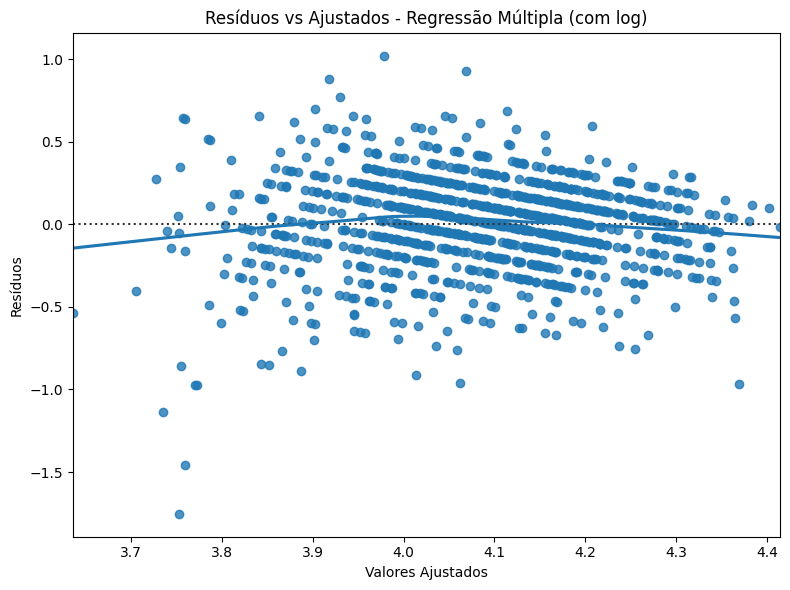

In [59]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que temos a função para filtro de reviews únicos
def filtra_reviews(df):
    return df.drop_duplicates(subset="review_id")

# 1️⃣ Garante que sent_positivo exista
if "sent_positivo" not in df.columns:
    df.loc[:, "sent_positivo"] = df["sentimento_ajustado"].apply(lambda x: 1 if x == "elogio" else 0)

# 2️⃣ Filtra reviews únicos
df_unico = filtra_reviews(df)

# 3️⃣ Garante tipos corretos
df_unico.loc[:, "rating"] = pd.to_numeric(df_unico["rating"], errors="coerce")
df_unico.loc[:, "discount_percentage"] = pd.to_numeric(df_unico["discount_percentage"], errors="coerce")
df_unico.loc[:, "actual_price"] = pd.to_numeric(df_unico["actual_price"], errors="coerce")
df_unico.loc[:, "rating_count"] = pd.to_numeric(df_unico["rating_count"], errors="coerce")
df_unico.loc[:, "sent_positivo"] = pd.to_numeric(df_unico["sent_positivo"], errors="coerce")

# 4️⃣ Criar coluna de preço com desconto
df_unico.loc[:, "discounted_price"] = df_unico["actual_price"] * (1 - df_unico["discount_percentage"])

# 5️⃣ Aplicar log nas variáveis
df_unico.loc[:, "log_discounted_price"] = np.log1p(df_unico["discounted_price"])
df_unico.loc[:, "log_rating_count"] = np.log1p(df_unico["rating_count"])

# 6️⃣ Reduzir categorias
top_categorias = df_unico["primeira_categoria"].value_counts().nlargest(3).index.tolist()
df_unico.loc[:, "categoria_reduzida"] = df_unico["primeira_categoria"].apply(lambda x: x if x in top_categorias else "Outros")

# 7️⃣ Selecionar variáveis e aplicar dummies
df_modelo = pd.get_dummies(df_unico[[ 
    "log_discounted_price", "log_rating_count", "discount_percentage",
    "sent_positivo", "categoria_reduzida", "rating"
]], columns=["categoria_reduzida"], drop_first=True)

# 8️⃣ Remover valores ausentes
df_modelo.dropna(inplace=True)

# 9️⃣ Garantir tipo numérico
df_modelo = df_modelo.astype("float64")

# 10️⃣ Definir X e y
X = sm.add_constant(df_modelo.drop(columns="rating"))
y = df_modelo["rating"]

# 11️⃣ Regressão linear múltipla
modelo = sm.OLS(y, X).fit()

# 12️⃣ Exibir resumo
print(modelo.summary())

# 13️⃣ VIF para multicolinearidade
vif = pd.DataFrame()
vif["variavel"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF:")
print(vif)

# 14️⃣ Diagnóstico de resíduos
plt.figure(figsize=(8, 6))
sns.residplot(x=modelo.fittedvalues, y=modelo.resid, lowess=True)
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Resíduos vs Ajustados - Regressão Múltipla (com log)")
plt.tight_layout()
plt.show()




A análise mostra que diversas variáveis estão associadas de forma significativa à nota média dos produtos (rating). A regressão linear confirma esses resultados: variáveis como preço com desconto (log), quantidade de avaliações (log), percentual de desconto, sentimento positivo e a categoria do produto influenciam de maneira relevante o rating. O sentimento positivo tem um impacto positivo significativo (coef. = 0,16; p < 0,001), indicando que avaliações com tom positivo tendem a resultar em notas mais altas. Já um maior percentual de desconto está associado a uma redução no rating (coef. = -0,15; p = 0,001). Produtos das categorias Electronics (coef. = -0,10; p < 0,001) e Home&Kitchen (coef. = -0,14; p < 0,001) tendem a receber avaliações ligeiramente mais baixas em média. O modelo é estatisticamente significativo (p < 0,0001) e apresenta um R² de 17,5%, explicando uma parcela relevante da variação nas notas. Assim, tanto características do produto quanto o conteúdo emocional das avaliações impactam de forma significativa a nota atribuída.



In [57]:
df.to_csv("dataset_final.csv", index=False)


In [58]:
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/awebe/vscode/codproj04/chave_projeto4lab.json"


from google.cloud import bigquery
import pandas as pd

# Inicializar o cliente
client = bigquery.Client()

# Defina o dataset e o nome da tabela
dataset_id = "projeto4lab.proj04"  # substitua "meu_dataset" pelo NOME DO DATASET que você criou no BigQuery
table_id = f"{dataset_id}.amazon_final"  # nome da tabela que será criada (ex: "amazon_final")

# Configuração do job
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"  # sobrescreve se a tabela já existir
)

# Enviar o dataframe para o BigQuery
job = client.load_table_from_dataframe(df, table_id, job_config=job_config)

# Aguarda o job finalizar
job.result()

print(f"Tabela {table_id} carregada com sucesso no BigQuery 🚀.")


Tabela projeto4lab.proj04.amazon_final carregada com sucesso no BigQuery 🚀.
